# An attempt at an elegant solution to the 2D -> 3D object relation problem.
I will use graph theory to solve this problem. 
The idea is to create a graph where each node represents a 2D object and each edge represents a potential relation between two objects across z or an absolute relation between two objects in the same z.
These edges will be weighted based on their z distance.
The problem then becomes a shortest path problem where we need to find the shortest path between the start and end nodes.
An issue that will arise is figuring out how many nodes might exist in a given path. This will vary and will be a challenge to solve.
Some nodes will not start until a certain z level and some nodes will end at a certain z level.

### To do this we must make the following assumptions:
1. Nodes in the same z level are connected to each other, but will not be used in the shortest path calculation - these are separate objects.
2. The variablility in the distance between the X-Y coordinates across z-slices for the same 3D object is minimal.
    - This will be a learned or assumed value - probably initialized as apriori knowledge.
3. The distance between the X-Y coordinates across z-slices for different 3D objects is significant.
4. Given the assumption of 1 and 2, we do not need to calculate the shortes path between all nodes, only the nodes that are within a certain distance of each other in the X-Y plane across z-slices.
5. The total number of objects in a 2D slice cannot be greater than the total number of objects in the 3D object.
6. The largest number of objects across all 2D slices will not necessarily be the same as the number of objects in the 3D object.
7. The node path has to be continuous and cannot skip nodes.

## Imports

In [1]:
import argparse
import pathlib
import sys

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import skimage
import skimage.io as io
import tifffile
from cellpose import core, models, utils
from rich.pretty import pprint

sys.path.append("../../utils")
import nviz
from nviz.image_meta import extract_z_slice_number_from_filename, generate_ome_xml
from segmentation_decoupling import euclidian_2D_distance

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

In [2]:
if not in_notebook:
    print("Running as script")
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--patient",
        type=str,
        help="The patient ID",
    )

    parser.add_argument(
        "--well_fov",
        type=str,
        help="Path to the input directory containing the tiff images",
    )
    parser.add_argument(
        "--radius_constraint",
        type=int,
        default=10,
        help="The maximum radius of the x-y vector",
    )
    parser.add_argument(
        "--compartment",
        type=str,
        default="none",
        help="The compartment to segment",
    )

    args = parser.parse_args()
    well_fov = args.well_fov
    x_y_vector_radius_max_constaint = args.radius_constraint
    compartment = args.compartment
    patient = args.patient
else:
    print("Running in a notebook")
    well_fov = "G11-2"
    compartment = "organoid"
    patient = "NF0014"

input_dir = pathlib.Path(f"../../data/{patient}/processed_data/{well_fov}").resolve()
mask_dir = pathlib.Path(f"../../data/{patient}/processed_data/{well_fov}").resolve()
if compartment == "nuclei":
    input_image_dir = pathlib.Path(mask_dir / "nuclei_masks_decoupled.tiff").resolve(
        strict=True
    )
    x_y_vector_radius_max_constaint = 10  # pixels
    output_image_dir = pathlib.Path(
        mask_dir / "nuclei_masks_reconstructed.tiff"
    ).resolve()
elif compartment == "cell":
    input_image_dir = pathlib.Path(mask_dir / "cell_masks_decoupled.tiff").resolve(
        strict=True
    )
    x_y_vector_radius_max_constaint = 40  # pixels
    output_image_dir = pathlib.Path(
        mask_dir / "cell_masks_reconstructed.tiff"
    ).resolve()
elif compartment == "organoid":
    input_image_dir = pathlib.Path(mask_dir / "organoid_masks_decoupled.tiff").resolve(
        strict=True
    )
    x_y_vector_radius_max_constaint = 1000  # pixels
    output_image_dir = pathlib.Path(
        mask_dir / "organoid_masks_reconstructed.tiff"
    ).resolve()
else:
    raise ValueError(
        "Invalid compartment, please choose either 'nuclei', 'cell', or 'organoid'"
    )

Running in a notebook


## Extract masks and masks centers (XY coordinates) from the input image

In [3]:
image = tifffile.imread(input_image_dir)

In [4]:
cordinates = {
    "original_label": [],
    "slice": [],
    "centroid-0": [],
    "centroid-1": [],
}

for slice in range(image.shape[0]):
    props = skimage.measure.regionprops_table(
        image[slice, :, :], properties=["label", "centroid"]
    )

    label, centroid1, centroid2 = (
        props["label"],
        props["centroid-0"],
        props["centroid-1"],
    )
    if len(label) > 0:
        for i in range(len(label)):
            cordinates["original_label"].append(label[i])
            cordinates["slice"].append(slice)
            cordinates["centroid-0"].append(centroid1[i])
            cordinates["centroid-1"].append(centroid2[i])


coordinates_df = pd.DataFrame(cordinates)
coordinates_df["unique_id"] = coordinates_df.index
coordinates_df.head()

,original_label,slice,centroid-0,centroid-1,unique_id
0,2,5,776.481312,866.721080,0
1,2,6,768.478462,859.643612,1
2,2,7,759.406055,854.281436,2
3,2,8,739.729050,842.269976,3
4,2,9,732.334373,840.127398,4


## Plot the coordinates of the masks in the XY plane

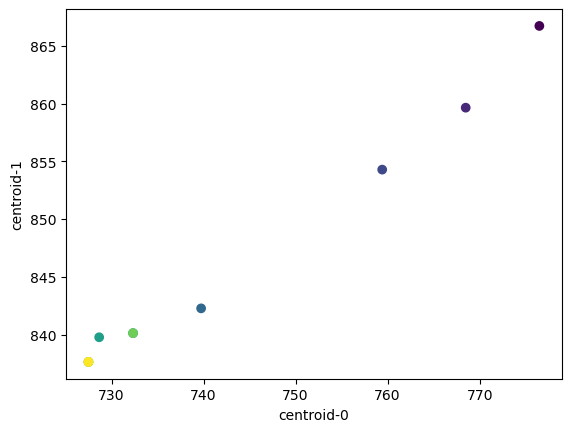

In [5]:
if in_notebook:
    # plot the data
    fig, ax = plt.subplots()
    plt.scatter(
        coordinates_df["centroid-0"],
        coordinates_df["centroid-1"],
        c=coordinates_df["unique_id"],
    )
    plt.xlabel("centroid-0")
    plt.ylabel("centroid-1")
    plt.show()

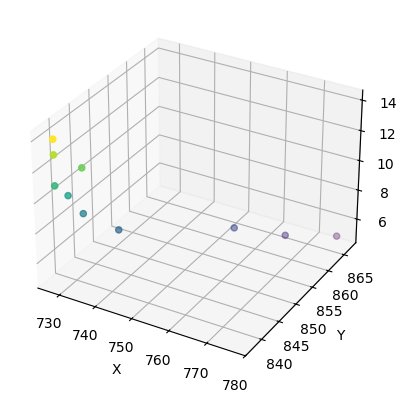

In [6]:
if in_notebook:
    # make a 3D graph of each x-y center of mass
    # Create a new figure
    fig = plt.figure()

    # Add a 3D subplot
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(
        coordinates_df["centroid-0"],
        coordinates_df["centroid-1"],
        coordinates_df["slice"],
        c=coordinates_df["unique_id"],
    )
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()

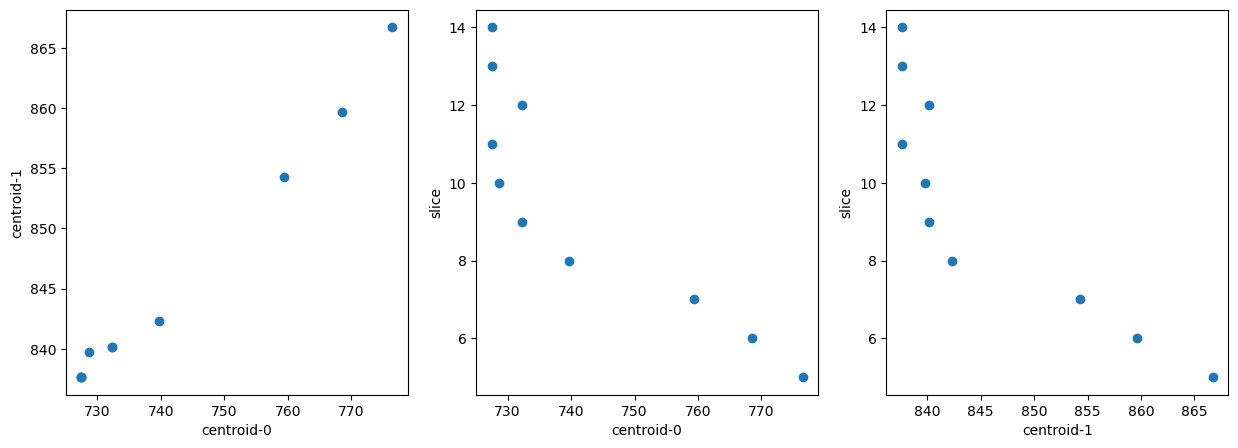

In [7]:
if in_notebook:
    # plot the centroid for x-y, x-z, and y-z
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].scatter(coordinates_df["centroid-0"], coordinates_df["centroid-1"])
    ax[0].set_xlabel("centroid-0")
    ax[0].set_ylabel("centroid-1")
    ax[1].scatter(coordinates_df["centroid-0"], coordinates_df["slice"])
    ax[1].set_xlabel("centroid-0")
    ax[1].set_ylabel("slice")
    ax[2].scatter(coordinates_df["centroid-1"], coordinates_df["slice"])
    ax[2].set_xlabel("centroid-1")
    ax[2].set_ylabel("slice")
    plt.show()

In [8]:
# generate distance pairs for each slice
# x_y_vector_radius_max_constaint = 50
distance_pairs = []
for i in range(coordinates_df.shape[0]):
    for j in range(coordinates_df.shape[0]):
        if i != j:
            coordinate_pair1 = coordinates_df.loc[
                i, ["centroid-0", "centroid-1"]
            ].values
            coordinate_pair2 = coordinates_df.loc[
                j, ["centroid-0", "centroid-1"]
            ].values
            distance = euclidian_2D_distance(coordinate_pair1, coordinate_pair2)
            if distance < x_y_vector_radius_max_constaint:
                distance_pairs.append(
                    {
                        "slice1": coordinates_df.loc[i, "slice"],
                        "slice2": coordinates_df.loc[j, "slice"],
                        "index1": i,
                        "index2": j,
                        "distance": distance,
                        "coordinates1": (coordinate_pair1[0], coordinate_pair1[1]),
                        "coordinates2": (coordinate_pair2[0], coordinate_pair2[1]),
                        "pass": True,
                        "original_label1": coordinates_df.loc[i, "original_label"],
                        "original_label2": coordinates_df.loc[j, "original_label"],
                    }
                )
            else:
                distance_pairs.append(
                    {
                        "slice1": coordinates_df.loc[i, "slice"],
                        "slice2": coordinates_df.loc[j, "slice"],
                        "index1": i,
                        "index2": j,
                        "distance": distance,
                        "coordinates1": (coordinate_pair1[0], coordinate_pair1[1]),
                        "coordinates2": (coordinate_pair2[0], coordinate_pair2[1]),
                        "pass": False,
                        "original_label1": coordinates_df.loc[i, "original_label"],
                        "original_label2": coordinates_df.loc[j, "original_label"],
                    }
                )
df = pd.DataFrame(distance_pairs)
df["indexes"] = df["index1"].astype(str) + "-" + df["index2"].astype(str)
df = df[df["pass"] == True]
df["index_comparison"] = df["index1"].astype(str) + "," + df["index2"].astype(str)
df.head()

,slice1,slice2,index1,index2,distance,coordinates1,coordinates2,pass,original_label1,original_label2,indexes,index_comparison
0,5,6,0,1,10.683452,"(776.4813118213391, 866.721079702818)","(768.4784621451104, 859.6436119873817)",True,2,2,0-1,"0,1"
1,5,7,0,2,21.126030,"(776.4813118213391, 866.721079702818)","(759.4060548695034, 854.2814355000844)",True,2,2,0-2,"0,2"
2,5,8,0,3,44.142782,"(776.4813118213391, 866.721079702818)","(739.7290500631916, 842.2699762709242)",True,2,2,0-3,"0,3"
3,5,9,0,4,51.538104,"(776.4813118213391, 866.721079702818)","(732.3343725643024, 840.1273979835566)",True,2,2,0-4,"0,4"
4,5,10,0,5,54.900040,"(776.4813118213391, 866.721079702818)","(728.6521436149843, 839.7695480484911)",True,2,2,0-5,"0,5"


In [9]:
# create a graph where each node is a unique centroid and each edge is a distance between centroids
# edges between nodes with the same slice are not allowed
# edge weight is the distance between the nodes (euclidian distance)
G = nx.Graph()
for row in df.iterrows():
    G.add_node(
        row[1]["index1"], slice=row[1]["slice1"], coordinates=row[1]["coordinates1"]
    )
    G.add_node(
        row[1]["index2"], slice=row[1]["slice2"], coordinates=row[1]["coordinates2"]
    )
    G.add_edge(
        row[1]["index1"],
        row[1]["index2"],
        weight=row[1]["distance"],
        original_label1=row[1]["original_label1"],
        original_label2=row[1]["original_label2"],
    )

# plot the graph with each slice being on a different row
pos = nx.spring_layout(G)
edge_labels = nx.get_edge_attributes(G, "weight")

# solve the the shortest path problem
# find the longest paths in the graph with the smallest edge weights
# this will find the longest paths between centroids closest to each other
# the longest path is the path with the most edges
longest_paths = []
for path in nx.all_pairs_shortest_path(G):
    longest_path = []
    for key in path[1].keys():
        if len(path[1][key]) > len(longest_path):
            longest_path = path[1][key]
    longest_paths.append(longest_path)

In [10]:
def merge_sets(list_of_sets: list) -> list:
    for i, set1 in enumerate(list_of_sets):
        for j, set2 in enumerate(list_of_sets):
            if i != j and len(set1.intersection(set2)) > 0:
                set1.update(set2)
    return list_of_sets

In [11]:
list_of_sets = [set(x) for x in longest_paths]
merged_sets = merge_sets(list_of_sets)

In [12]:
merged_sets_dict = {}
for i in range(len(list_of_sets)):
    merged_sets_dict[i] = list_of_sets[i]

In [13]:
coordinates_df.head()

,original_label,slice,centroid-0,centroid-1,unique_id
0,2,5,776.481312,866.721080,0
1,2,6,768.478462,859.643612,1
2,2,7,759.406055,854.281436,2
3,2,8,739.729050,842.269976,3
4,2,9,732.334373,840.127398,4


In [14]:
for row in coordinates_df.iterrows():
    for num_set in merged_sets_dict:
        if int(row[1]["unique_id"]) in merged_sets_dict[num_set]:
            coordinates_df.at[row[0], "label"] = num_set
# drop nan
coordinates_df = coordinates_df.dropna()

In [15]:
new_mask_image = np.zeros_like(image)
# mask label reassignment
for slice in range(image.shape[0]):
    mask = image[slice, :, :]
    tmp_df = coordinates_df[coordinates_df["slice"] == slice]
    for i in range(tmp_df.shape[0]):
        mask[mask == tmp_df.iloc[i]["original_label"]] = tmp_df.iloc[i]["label"]

    new_mask_image[slice, :, :] = mask
# save the new image
tifffile.imwrite(output_image_dir, new_mask_image)

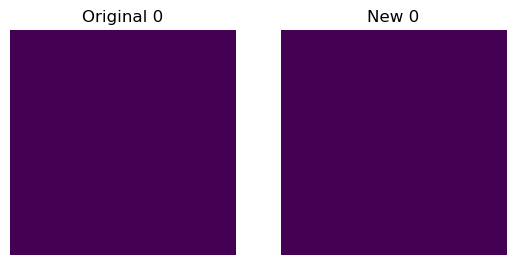

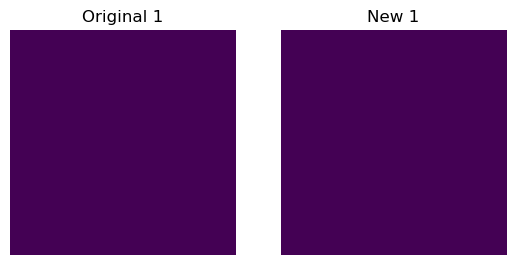

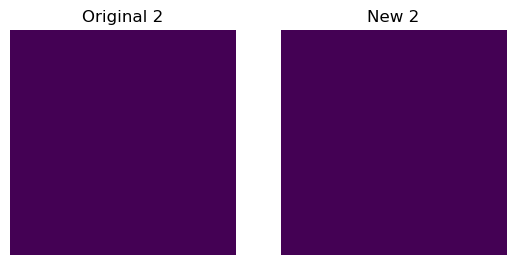

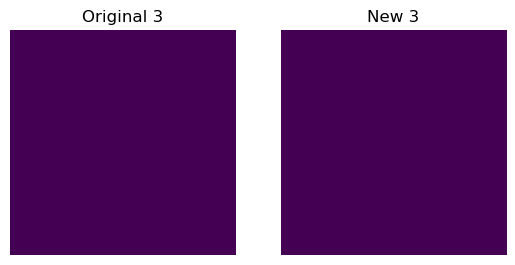

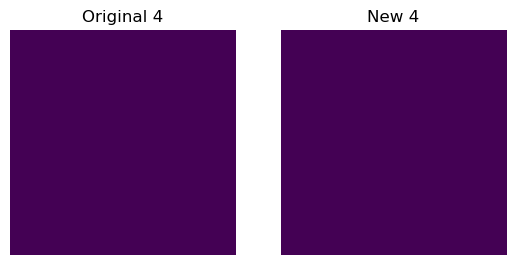

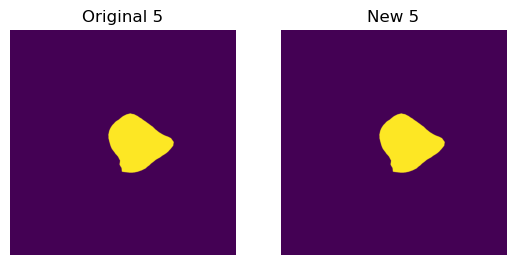

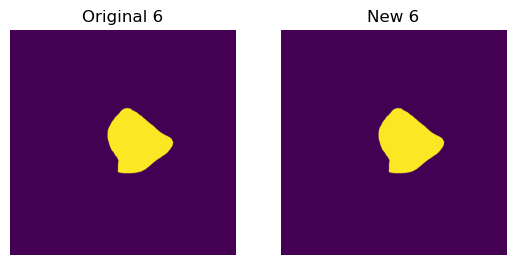

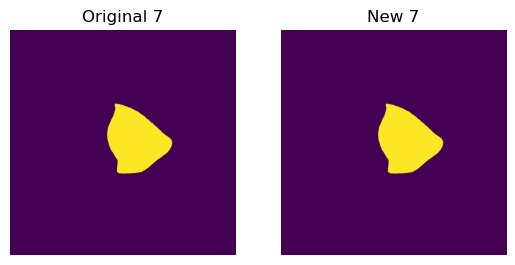

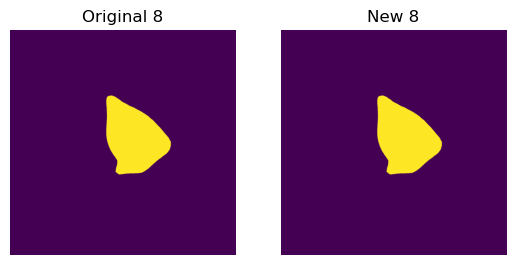

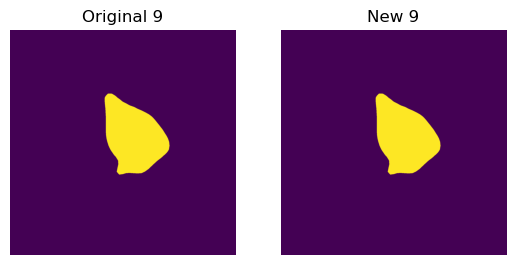

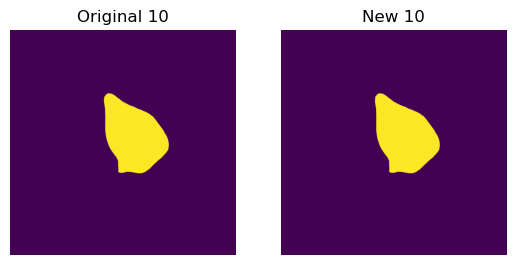

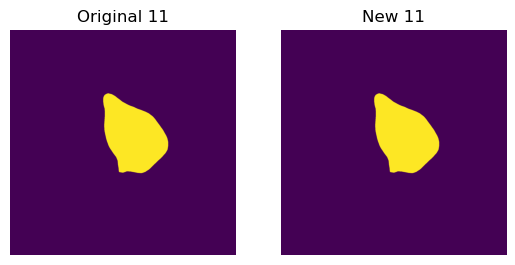

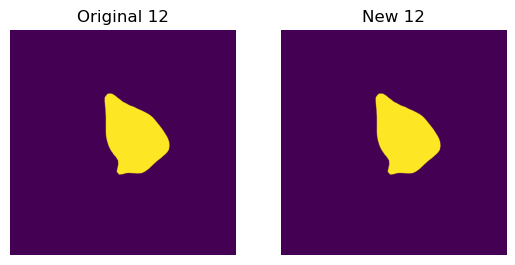

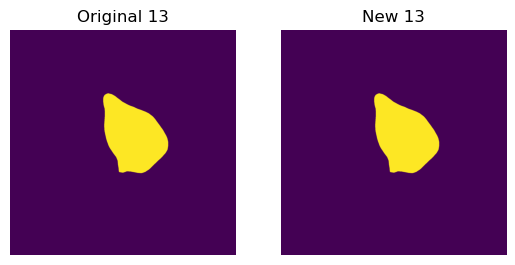

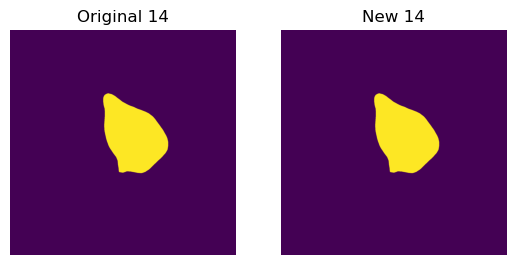

In [16]:
if in_notebook:
    for slice in range(new_mask_image.shape[0]):
        plt.subplot(1, 2, 1)
        plt.imshow(image[slice, :, :])
        plt.title(f"Original {slice}")
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(new_mask_image[slice, :, :])
        plt.title(f"New {slice}")
        plt.axis("off")
        plt.show()